# Word2Vec

**Word2Vec** is a group if algorithms to learn vector space representations of the words (also called word embeddings) . **Word2Vec** technique has two different algorithms:
1. Continuous Bag of Words (CBOW)
2. Skip gram method

Both of the techniques were described in these two papers.

https://arxiv.org/abs/1301.3781

https://arxiv.org/abs/1310.4546

In the sheet below we will implement Skip gram method from scratch. Later we will use gensim to make word embeddings and see some its properties.

In [1]:
import numpy as np
import string
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jamieott/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamieott/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class Word2Vec:
    def __init__(self, embed_d, learning_rate, epochs, window_size):
        self.embed_d       = embed_d
        self.learning_rate = learning_rate
        self.epochs        = epochs
        self.window_size   = window_size
    
    def _word2onehot(self, word):
        word_vec = [0 for i in range(0, self.vocab_size)]
        word_index = self.word_index[word]
        word_vec[word_index] = 1
        return word_vec
    
    def prepare_data(self, corpus):
        word_counts = defaultdict(int)
        for row in corpus:
            for word in row:
                word_counts[word] += 1

        self.vocab_size = len(word_counts.keys())

        self.words_list = sorted(list(word_counts.keys()),reverse=False)
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))

        self.training_data = []
        for sentence in corpus:
            sent_len = len(sentence)
            for i, word in enumerate(sentence):
                w_target = self._word2onehot(sentence[i])
                w_context = []
                for j in range(i-self.window_size, i+self.window_size+1):
                    if j!=i and j<sent_len and j>=0:
                        w_context.append(self._word2onehot(sentence[j]))
                self.training_data.append([w_target, w_context])
    
    def init_weights(self):
        self.w1 = np.random.uniform(-1, 1, (self.vocab_size, self.embed_d))     
        self.w2 = np.random.uniform(-1, 1, (self.embed_d, self.vocab_size))     
    
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def _forward_pass(self, x):
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self._softmax(u)
        return y_c, h, u
    
    def _backprop(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

        self.w1 = self.w1 - (self.learning_rate * dl_dw1)
        self.w2 = self.w2 - (self.learning_rate * dl_dw2)
    
    def fit(self):
        self.init_weights()
        self.losses = []
        for i in range(0, self.epochs):
            loss = 0
            for t, c in self.training_data:
                y_pred, h, u = self._forward_pass(t)
                
                err = np.sum([np.subtract(y_pred, word) for word in c], axis=0)

                self._backprop(err, h, t)

                loss += -np.sum([u[word.index(1)] for word in c]) + len(c) * np.log(np.sum(np.exp(u)))
            if i % 100 == 0:
                print(f"EPOCH: {i}, LOSS: {loss}")
            self.losses.append(loss)

    def word_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w

    def vec_sim(self, vec, top_n):
        word_sim = {}
        for i in range(self.vocab_size):
            v_w2 = self.w1[i]
            theta_num = np.dot(vec, v_w2)
            theta_den = np.linalg.norm(vec) * np.linalg.norm(v_w2)
            theta = theta_num / theta_den

            word = self.index_word[i]
            word_sim[word] = theta

        words_sorted = sorted(word_sim.items(), key=lambda item : item[1], reverse=True)

        for word, sim in words_sorted[:top_n]:
            print(word, sim)
            

In [3]:
word2vec = Word2Vec(10, 0.01, 1000, 2)
text="""Word2vec is a technique for natural language processing. 
The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. 
Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. 
As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. 
The vectors are chosen carefully such that a simple mathematical function 
(the cosine similarity between the vectors) indicates the level of semantic similarity between the words 
represented by those vectors."""

stop = set(stopwords.words('english') + list(string.punctuation))

corpus = []
for sent in sent_tokenize(text):
    sent_split = []
    for w in word_tokenize(sent.lower()):
        if w not in stop:
            sent_split.append(w)
    corpus.append(sent_split)
word2vec.prepare_data(corpus)
word2vec.fit()

EPOCH: 0, LOSS: 799.9936433848986
EPOCH: 100, LOSS: 337.2295425751781
EPOCH: 200, LOSS: 292.7990057219159
EPOCH: 300, LOSS: 286.095814277507
EPOCH: 400, LOSS: 283.97845091584327
EPOCH: 500, LOSS: 282.9892427981479
EPOCH: 600, LOSS: 282.415675811719
EPOCH: 700, LOSS: 282.03245900455823
EPOCH: 800, LOSS: 281.7496210019721
EPOCH: 900, LOSS: 281.52545280806567


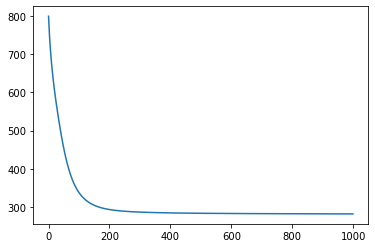

In [4]:
plt.plot(word2vec.losses)

In [5]:
word2vec.word_vec('neural')

array([ 1.11063421, -1.11807186, -0.52986382, -1.21634822, -2.05934472,
        0.27011979, -0.49927939, -2.10755115,  0.72212965, -0.97921892])

In [6]:
word2vec.vec_sim(word2vec.word_vec('network'),4)

network 0.9999999999999999
algorithm 0.6344168180957185
associations 0.5511618179731903
neural 0.5083719112122781


## GenSim
Now lets use **GenSim** to generate word embeddings

In [7]:
df = pd.read_csv('./simpsons_dataset.csv')

In [8]:
df.head()
df = df.dropna().reset_index(drop=True)

In [9]:
import spacy

In [10]:
nlp = spacy.load("en_core_web_sm")
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, disable=["parser", "ner"])]

In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(107505, 1)

In [12]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [13]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [14]:
word2Vec_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
word2Vec_model.build_vocab(sentences, progress_per=10000)

In [15]:
word2Vec_model.train(df_clean["clean"], total_examples=word2Vec_model.corpus_count, epochs=100, report_delay=1)

(147887018, 331906000)

In [16]:
word2Vec_model.wv.most_similar(positive=["bart"])

[('wheel', 0.1806177943944931),
 ('horse', 0.1788918673992157),
 ('drown', 0.17627103626728058),
 ('jacket', 0.1736503392457962),
 ('lick', 0.1733086258172989),
 ('restaurant', 0.16978919506072998),
 ('especially', 0.1688036322593689),
 ('peach', 0.16804105043411255),
 ('q', 0.1659407615661621),
 ('source', 0.16477200388908386)]

Lets try out some other corpus

In [17]:
import gensim.downloader as api
corpus = api.load('text8')

model = Word2Vec(corpus)

In [18]:
print(model.wv.most_similar('tree'))

[('trees', 0.6888453960418701), ('leaf', 0.6712740659713745), ('fruit', 0.6434304118156433), ('flower', 0.6400408744812012), ('bark', 0.6394050121307373), ('bird', 0.6125483512878418), ('avl', 0.6082426309585571), ('bee', 0.5910632610321045), ('garden', 0.5887804627418518), ('cactus', 0.5871884822845459)]
